In [80]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('./')
import json
import os
from qiskit import QuantumCircuit
import numpy as np
from dataclasses import dataclass
from enum import auto, Enum
import matplotlib.pyplot as plt
import math

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [81]:
from dataclasses import dataclass

@dataclass
class ResultOfSchedule:
    numcircuit: int
    nameAlgorithm: str
    averageQubits: float
    nameSchedule: str
    typeMachine: dict
    
    # Metrics
    average_turnaroundTime: float
    average_ResponseTime: float
    average_fidelity: float
    samping_overhead: float
    average_throughput: float
    average_utilization: float
    time_generation: float
    makespan: float
    
result_Schedule = ResultOfSchedule(
    numcircuit=0,
    nameAlgorithm="",
    averageQubits=0.0,
    nameSchedule="",
    typeMachine={},
    
    # Metrics
    average_turnaroundTime=0.0,
    average_ResponseTime=0.0,
    average_fidelity=0.0,
    samping_overhead=0.0,
    average_throughput=0.0,
    average_utilization=0.0,
    time_generation=0.0,
    makespan=0.0
)

In [82]:
from component.sup_sys.algorithm_loader import load_algorithms
load_algorithms()

,Algorithm Type,Algorithm
0,ilp,MILQ_extend
1,ilp,NoTaDS
2,ai,(none)
3,heuristic,SJFS


In [83]:
# from component.a_backend.fake_backend import *
# from component.sup_sys.backend_loader import load_backends
# backendlist = load_backends()
# print(backendlist)

from qiskit.visualization import plot_error_map
from component.a_backend.fake_backend import *
machines = {}
backend0 = FakeBelemV2()
backend1 = FakeManilaV2()

machines[backend0.name] = backend0
machines[backend1.name] = backend1
print(machines)
# plot_error_map(list(machines.values())[0], figsize=(10, 8))

{'fake_belem': <qiskit_ibm_runtime.fake_provider.backends.belem.fake_belem.FakeBelemV2 object at 0x7b523c374640>, 'fake_manila': <qiskit_ibm_runtime.fake_provider.backends.manila.fake_manila.FakeManilaV2 object at 0x7b523c377f70>}


In [84]:
# create a dictionary of jobs with job_id as key and number of qubits as value
num_qubits_per_job = 2
num_jobs = 3
jobs = {}

for i in range(num_jobs):
    job_id = str(i + 1)
    jobs[job_id] = num_qubits_per_job

# update numcircuit
result_Schedule.numcircuit = len(jobs)
result_Schedule.averageQubits = sum(jobs.values()) / len(jobs)

# Generate the problem

Create benchmark

In [85]:
from component.b_benchmark.mqt_tool import benchmark_circuit
from component.sup_sys.job_info import JobInfo

origin_job_info = {}

for job_name, num_qubits in jobs.items():
    circuit = benchmark_circuit(name_algorithm="ghz", circuit_size=num_qubits)
    result_Schedule.nameAlgorithm = "ghz"
    circuit.remove_final_measurements()
    origin_job_info[job_name] = JobInfo(
        job_name=job_name,
        qubits=circuit.num_qubits,
        machine=None,  # Placeholder for machine name
        capacity_machine=0,  # Placeholder for machine capacity
        start_time=0.0,  # Placeholder for start time
        duration=0.0,  # Placeholder for duration
        end_time=0.0,  # Placeholder for end time
        childrenJobs=None,  # Placeholder for child jobs
        circuit=circuit,
        result_cut=None,  # Placeholder for result cut
    )

for job in origin_job_info.values():
    job.print()

# origin_job_info['3'].circuit.draw('mpl')

Job ID: d3e18d52-9e6c-4dd9-a369-7d7e50fb2516
Job Name: 1
Circuit:           ┌───┐
q_0: ─────┤ X ├
     ┌───┐└─┬─┘
q_1: ┤ H ├──■──
     └───┘     
Qubits: 2
Machine: None
Capacity Machine: 0
Start Time: 0.0
Duration: 0.0
End Time: 0.0
Children Jobs: None
Result Cut: None
Transpiled Circuit: None
Transpiled Circuit Measured: None
Fidelity: None
Job ID: d3e18d52-9e6c-4dd9-a369-7d7e50fb2516
Job Name: 2
Circuit:           ┌───┐
q_0: ─────┤ X ├
     ┌───┐└─┬─┘
q_1: ┤ H ├──■──
     └───┘     
Qubits: 2
Machine: None
Capacity Machine: 0
Start Time: 0.0
Duration: 0.0
End Time: 0.0
Children Jobs: None
Result Cut: None
Transpiled Circuit: None
Transpiled Circuit Measured: None
Fidelity: None
Job ID: d3e18d52-9e6c-4dd9-a369-7d7e50fb2516
Job Name: 3
Circuit:           ┌───┐
q_0: ─────┤ X ├
     ┌───┐└─┬─┘
q_1: ┤ H ├──■──
     └───┘     
Qubits: 2
Machine: None
Capacity Machine: 0
Start Time: 0.0
Duration: 0.0
End Time: 0.0
Children Jobs: None
Result Cut: None
Transpiled Circuit: None
Transpiled Cir

Cutting circuit

In [86]:
# cutting each job into 2 parts in dict_job_info
process_job_info = origin_job_info.copy()
# for job in process_job_info.values():
#     job.print()

cal value from backend

In [87]:
# Cutting the jobs into two parts with condition in process_job_info
from component.c_circuit_work.cutting.width_c import *

max_width = max(list(machines.values()), key=lambda x: x.num_qubits).num_qubits

for job_name, job_info in process_job_info.items():
    if job_info.qubits > max_width:
        job_info.childrenJobs = []
        cut_name, observable = greedy_cut(job_info.circuit, max_width)
        print(observable)
        result_cut = gate_to_reduce_width(job_info.circuit, cut_name, observable)
        result_Schedule.samping_overhead += result_cut.overhead
        for i, (subcircuit_name, subcircuit) in enumerate(result_cut.subcircuits.items()):
            job_info.childrenJobs.append(
                JobInfo(
                    job_name=f"{job_name}_{i+1}",
                    qubits=subcircuit.num_qubits,
                    machine=None,
                    capacity_machine=0,
                    start_time=0.0,
                    duration=0.0,
                    end_time=0.0,
                    childrenJobs=None,
                    circuit=subcircuit,
                    result_cut=None,
                )
            )
        job_info.result_cut = result_cut
    # job_info.print()

In [88]:
# 4. Run subexperiments on a quantum backend
for job_name, job_info in process_job_info.items():
    if job_info.result_cut is not None:
        result_cut = job_info.result_cut
        backend = list(machines.values())[0] # Example backend
        results = run_subexperiments(result_cut.subexperiments, backend)
        reconstructed_expval, exact_expval, error_estimation, relative_error_estimation = compute_expectation_value(results, result_cut.coefficients, result_cut.subobservables, result_cut.observable, job_info.circuit)
        print_results(reconstructed_expval, exact_expval, error_estimation, relative_error_estimation)

Apply scheduling to the benchmark circuits as require ment

In [89]:
# Get the job for run scheduler

scheduler_job = {}
def get_scheduler_jobs(job_info):
    if job_info.childrenJobs is None:
        return {job_info.job_name: job_info}
    scheduler_jobs = {}
    for child_job in job_info.childrenJobs:
        scheduler_jobs.update(get_scheduler_jobs(child_job))
    return scheduler_jobs

for job_name, job_info in process_job_info.items():
    scheduler_job.update(get_scheduler_jobs(job_info))
    
print("Scheduler Jobs:")
for job_name, job_info in scheduler_job.items():
    job_info.print()

Scheduler Jobs:
Job ID: d3e18d52-9e6c-4dd9-a369-7d7e50fb2516
Job Name: 1
Circuit:           ┌───┐
q_0: ─────┤ X ├
     ┌───┐└─┬─┘
q_1: ┤ H ├──■──
     └───┘     
Qubits: 2
Machine: None
Capacity Machine: 0
Start Time: 0.0
Duration: 0.0
End Time: 0.0
Children Jobs: None
Result Cut: None
Transpiled Circuit: None
Transpiled Circuit Measured: None
Fidelity: None
Job ID: d3e18d52-9e6c-4dd9-a369-7d7e50fb2516
Job Name: 2
Circuit:           ┌───┐
q_0: ─────┤ X ├
     ┌───┐└─┬─┘
q_1: ┤ H ├──■──
     └───┘     
Qubits: 2
Machine: None
Capacity Machine: 0
Start Time: 0.0
Duration: 0.0
End Time: 0.0
Children Jobs: None
Result Cut: None
Transpiled Circuit: None
Transpiled Circuit Measured: None
Fidelity: None
Job ID: d3e18d52-9e6c-4dd9-a369-7d7e50fb2516
Job Name: 3
Circuit:           ┌───┐
q_0: ─────┤ X ├
     ┌───┐└─┬─┘
q_1: ┤ H ├──■──
     └───┘     
Qubits: 2
Machine: None
Capacity Machine: 0
Start Time: 0.0
Duration: 0.0
End Time: 0.0
Children Jobs: None
Result Cut: None
Transpiled Circuit: Non

In [90]:
# Setup
bigM = 1000000
timesteps = 2**5
jobs = ["0"] + list(scheduler_job.keys())
job_capacities = {"0": 0}
job_capacities.update({job_name: job_info.qubits for job_name, job_info in scheduler_job.items()})
machines_ilp = list(machines.keys())  # Keep machines as a list of keys
machine_capacities_ilp = {machine_name: machines[machine_name].num_qubits for machine_name in machines}
result_Schedule.typeMachine = machine_capacities_ilp
print("Jobs:", jobs)
print("Job Capacities:", job_capacities)
print("Machines:", machines_ilp)
print("Machine Capacities:", machine_capacities_ilp)
result_Schedule.nameSchedule = "MILQ_extend"
from component.d_scheduling.algorithm.ilp.MILQ_extend import MILQ_extend_implementation
import time
# Measure runtime
start_time = time.time()
MILQ_extend_implementation.example_problem(bigM, timesteps, "component/d_scheduling/algorithm/ilp/MILQ_extend/MILQ_extend_result", jobs, job_capacities, machines_ilp, machine_capacities_ilp)
runtime = time.time() - start_time
result_Schedule.makespanSchedule = runtime
print(f"Runtime for scheduling: {runtime} seconds")

Jobs: ['0', '1', '2', '3']
Job Capacities: {'0': 0, '1': 2, '2': 2, '3': 2}
Machines: ['fake_belem', 'fake_manila']
Machine Capacities: {'fake_belem': 5, 'fake_manila': 5}
Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /home/trieu/anaconda3/envs/squan/lib/python3.10/site-packages/pulp/apis/../solverdir/cbc/linux/i64/cbc /tmp/469f1b94165b4a58bc09098faa6de6a6-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /tmp/469f1b94165b4a58bc09098faa6de6a6-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 493 COLUMNS
At line 3022 RHS
At line 3511 BOUNDS
At line 3830 ENDATA
Problem MODEL has 488 rows, 326 columns and 1891 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 8 - 0.00 seconds
Cgl0002I 6 variables fixed
Cgl0003I 0 fixed, 0 tightened bounds, 372 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 327 strengt

In [91]:
print(result_Schedule)

ResultOfSchedule(numcircuit=3, nameAlgorithm='ghz', averageQubits=2.0, nameSchedule='MILQ_extend', typeMachine={'fake_belem': 5, 'fake_manila': 5}, average_turnaroundTime=0.0, average_ResponseTime=0.0, average_fidelity=0.0, samping_overhead=0.0, average_throughput=0.0, average_utilization=0.0, time_generation=0.0, makespan=0.0)


In [92]:
# Read_ilp_result
from component.d_scheduling.extract import ilp
ilp.extract_data("component/d_scheduling/algorithm/ilp/MILQ_extend/MILQ_extend_result.json")

Saved job data as JSON to: /home/trieu/D/Quantum_Repo/Quantum_Simulation_Scheduling/component/d_scheduling/scheduleResult/ilp/MILQ_extend/schedule.json


Jobs have Updated Information:


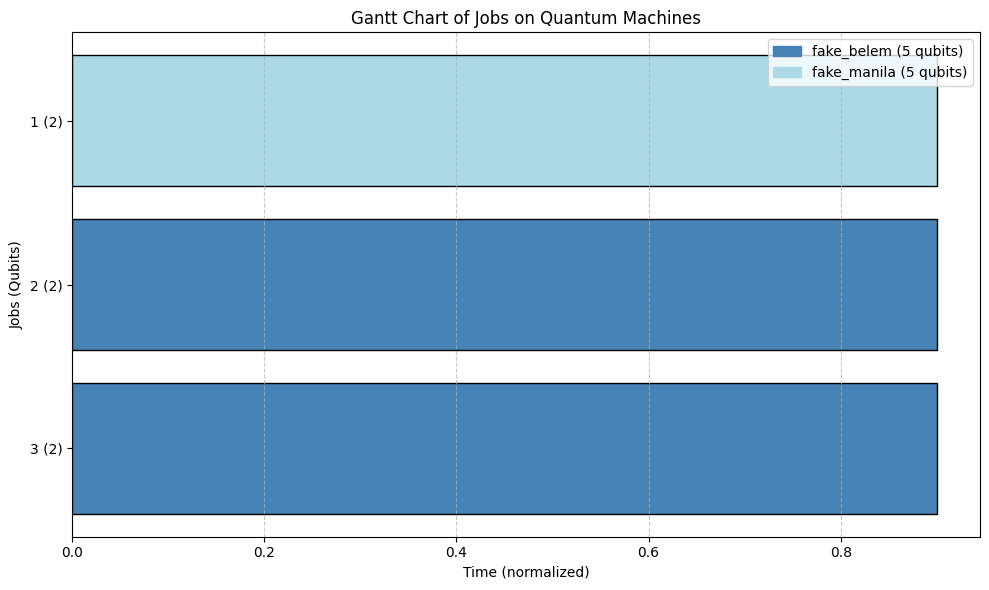

In [93]:
# Visualize data and update to dict
from component.d_scheduling.analyze import analyze_cal
from component.d_scheduling.datawork.visualize import visualize_data
from component.d_scheduling.datawork.updateToDict import update_scheduler_jobs
data = analyze_cal.load_job_data("component/d_scheduling/scheduleResult/ilp/MILQ_extend/schedule.json")
update_scheduler_jobs(data, scheduler_job)
visualize_data(data)

In [94]:
from qiskit import QuantumCircuit, transpile
# Transpile circuits for all scheduled jobs
for job_id, job in scheduler_job.items():
    backend = machines.get(job.machine)
    if backend:
        # Perform transpilation
        job.circuit.data = [hasChange for hasChange in job.circuit.data if hasChange.operation.name != "qpd_1q"]
        job.transpiled_circuit = transpile(job.circuit, backend, scheduling_method='alap', layout_method='trivial')
        job.circuit.measure_all()
        job.transpiled_circuit_measured = transpile(job.circuit, backend, scheduling_method='alap', layout_method='trivial')
    else:
        print(f"No backend found for machine {job.machine}. Skipping job {job_id}.")
        
    job.print()
    
# from qiskit.visualization.timeline import draw, IQXDebugging
# draw(scheduler_job['1'].transpiled_circuit, target=machines['fake_belem'].target)

# after have the circuit we connect to
# from qiskit.visualization import plot_circuit_layout
# plot_circuit_layout(scheduler_job['1'].transpiled_circuit, machines['fake_belem'])

Job ID: d3e18d52-9e6c-4dd9-a369-7d7e50fb2516
Job Name: 1
Circuit:              ┌───┐ ░ ┌─┐   
   q_0: ─────┤ X ├─░─┤M├───
        ┌───┐└─┬─┘ ░ └╥┘┌─┐
   q_1: ┤ H ├──■───░──╫─┤M├
        └───┘      ░  ║ └╥┘
meas: 2/══════════════╩══╩═
                      0  1 
Qubits: 2
Machine: fake_manila
Capacity Machine: 5
Start Time: 0.0
Duration: 9.0
End Time: 9.0
Children Jobs: None
Result Cut: None
Transpiled Circuit: global phase: π/4
                ┌────────────────┐                 ┌───┐
      q_0 -> 0 ─┤ Delay(160[dt]) ├─────────────────┤ X ├
                └──┬─────────┬───┘┌────┐┌─────────┐└─┬─┘
      q_1 -> 1 ────┤ Rz(π/2) ├────┤ √X ├┤ Rz(π/2) ├──■──
               ┌───┴─────────┴───┐└────┘└─────────┘     
ancilla_0 -> 2 ┤ Delay(1568[dt]) ├──────────────────────
               ├─────────────────┤                      
ancilla_1 -> 3 ┤ Delay(1568[dt]) ├──────────────────────
               ├─────────────────┤                      
ancilla_2 -> 4 ┤ Delay(1568[dt]) ├─────────────────────

In [95]:
print(data)

[{'job': '1', 'qubits': 2, 'machine': 'fake_manila', 'capacity': 5, 'start': 0.0, 'end': 0.9, 'duration': 0.9}, {'job': '2', 'qubits': 2, 'machine': 'fake_belem', 'capacity': 5, 'start': 0.0, 'end': 0.9, 'duration': 0.9}, {'job': '3', 'qubits': 2, 'machine': 'fake_belem', 'capacity': 5, 'start': 0.0, 'end': 0.9, 'duration': 0.9}]


# Allow multithreading

In [96]:
import random

# Define the jobs
jobs = data.copy()

# Generate unique execution times
def get_the_duration_from_transpiled_circuit(circuit):
    return circuit.duration

# Simulate the scheduling with parallel execution support
def simulate_scheduling(jobs):
    machine_schedules = {'fake_belem': [], 'fake_manila': []}  # Track active jobs for each machine
    jobs = sorted(jobs, key=lambda x: x['start'])  # Sort jobs by start time
    for job in jobs:
        machine = job['machine']
        # base_duration = job['duration']
        unique_duration = get_the_duration_from_transpiled_circuit(scheduler_job[job['job']].transpiled_circuit)

        # Find the earliest time the job can start
        current_schedule = machine_schedules[machine]
        start_time = job['start']
        
        # Check for parallel execution
        while True:
            # Filter out completed jobs
            active_jobs = [j for j in current_schedule if j['end'] > start_time]
            
            # Calculate total qubits in use
            total_qubits_in_use = sum(j['qubits'] for j in active_jobs)
            if total_qubits_in_use + job['qubits'] <= job['capacity']:
                # Enough resources are available
                break
            # Increment start_time to the earliest end time of active jobs
            start_time = min(j['end'] for j in active_jobs)

        # Update job start, end times, and duration
        job['start'] = start_time
        job['end'] = start_time + unique_duration
        job['duration'] = unique_duration

        # Add job to the machine's schedule
        current_schedule.append(job)

    return jobs

# Run the simulation
updated_jobs = simulate_scheduling(jobs)

# Print the updated schedule
for job in updated_jobs:
    print(job)


{'job': '1', 'qubits': 2, 'machine': 'fake_manila', 'capacity': 5, 'start': 0.0, 'end': 1568.0, 'duration': 1568}
{'job': '2', 'qubits': 2, 'machine': 'fake_belem', 'capacity': 5, 'start': 0.0, 'end': 3648.0, 'duration': 3648}
{'job': '3', 'qubits': 2, 'machine': 'fake_belem', 'capacity': 5, 'start': 0.0, 'end': 3648.0, 'duration': 3648}


/tmp/ipykernel_7729/856511553.py:8: DeprecationWarning: The property ``qiskit.circuit.quantumcircuit.QuantumCircuit.duration`` is deprecated as of qiskit 1.3.0. It will be removed in Qiskit 2.0.0.
  return circuit.duration


# Don't allow multithreading

In [70]:
import random

# Define the jobs
jobs = data.copy()

# Generate unique execution times
def get_the_duration_from_transpiled_circuit(circuit):
    return circuit.duration

# Simulate the scheduling with parallel execution support
# Simulate the scheduling with parallel execution support
def simulate_scheduling(jobs):
    machine_current = {'fake_belem': [], 'fake_manila': []}  # Track active jobs for each machine
    
    ready_queue = {'fake_belem': [], 'fake_manila': []}  # Jobs ready to be executed on each machine
    
    # update job with unique execution times
    for job in jobs:
        job['duration'] = get_the_duration_from_transpiled_circuit(scheduler_job[job['job']].transpiled_circuit)
        job['end'] = job['start'] + job['duration']
    
    # Schedule jobs on each machine
    jobs_QUITO = [job for job in jobs if job['machine'] == 'fake_belem']
    jobs_MANILA = [job for job in jobs if job['machine'] == 'fake_manila']
    
    current_time_QUITO = 0.0
    current_time_BELEM = 0.0
    current_capacity_QUITO = 5
    current_capacity_BELEM = 5
    
    # Schedule jobs on QUITO machine
    while jobs_QUITO:
        # Check if there are any jobs ready to be executed
        for job in jobs_QUITO[:]:  # Iterate over a copy to allow modification
            if job['start'] <= current_time_QUITO and job['qubits'] <= current_capacity_QUITO:
                ready_queue['fake_belem'].append(job)
                current_capacity_QUITO -= job['qubits']
        
        # Execute jobs in the ready queue in parallel
        if ready_queue['fake_belem']:
            max_end_time = current_time_QUITO
            for job in ready_queue['fake_belem']:
                job['start'] = current_time_QUITO
                job['end'] = job['start'] + job['duration']
                max_end_time = max(max_end_time, job['end'])
                current_capacity_QUITO += job['qubits']
                jobs_QUITO.remove(job)
                machine_current['fake_belem'].append(job)
            ready_queue['fake_belem'] = []
            # Move the current time to the end of the last job in parallel
            current_time_QUITO = max_end_time
        else:
            # If no jobs are ready, move to the next time step
            current_time_QUITO += 1.0
        
    # Schedule jobs on BELEM machine
    while jobs_MANILA:
        # Check if there are any jobs ready to be executed
        for job in jobs_MANILA[:]:  # Iterate over a copy to allow modification
            if job['start'] <= current_time_BELEM and job['qubits'] <= current_capacity_BELEM:
                ready_queue['fake_manila'].append(job)
                current_capacity_BELEM -= job['qubits']
        
        # Execute jobs in the ready queue in parallel
        if ready_queue['fake_manila']:
            max_end_time = current_time_BELEM
            for job in ready_queue['fake_manila']:
                job['start'] = current_time_BELEM
                job['end'] = job['start'] + job['duration']
                max_end_time = max(max_end_time, job['end'])
                current_capacity_BELEM += job['qubits']
                jobs_MANILA.remove(job)
                machine_current['fake_manila'].append(job)
            ready_queue['fake_manila'] = []
            # Move the current time to the end of the last job in parallel
            current_time_BELEM = max_end_time
        else:
            # If no jobs are ready, move to the next time step
            current_time_BELEM += 1.0
    

    return machine_current
        
# Run the simulation
updated_jobs = simulate_scheduling(jobs)
# Print the updated schedule
for machine, scheduled_jobs in updated_jobs.items():
    for job in scheduled_jobs:
        print(job)  

Final Schedule:
Machine fake_belem:
{'job': '1', 'qubits': 2, 'machine': 'fake_belem', 'capacity': 5, 'start': 0.0, 'end': 3648.0, 'duration': 3648}
{'job': '2', 'qubits': 2, 'machine': 'fake_belem', 'capacity': 5, 'start': 0.0, 'end': 3648.0, 'duration': 3648}
Machine fake_manila:
{'job': '3', 'qubits': 2, 'machine': 'fake_manila', 'capacity': 5, 'start': 0.0, 'end': 1568.0, 'duration': 1568}


/tmp/ipykernel_7729/1230890670.py:8: DeprecationWarning: The property ``qiskit.circuit.quantumcircuit.QuantumCircuit.duration`` is deprecated as of qiskit 1.3.0. It will be removed in Qiskit 2.0.0.
  return circuit.duration


assemble the circuit to have the output in backend and ideal

In [98]:
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_distribution
import qiskit.quantum_info as qi
from qiskit import transpile
from qiskit_ibm_runtime import SamplerV2
from component.f_assemble.assemble_work import fidelity_from_counts

aer_simulator = AerSimulator()
for job_name, job_info in scheduler_job.items():
    backend = machines.get(job_info.machine)
    
    if backend:
        transpiled_circuit = job_info.transpiled_circuit_measured
        
        # Run the ideal simulation
        ideal_result = aer_simulator.run(transpiled_circuit, shots=1024).result()
        ideal_counts = ideal_result.get_counts(transpiled_circuit)
        
        # Run circuit on the simulated backend
        job = SamplerV2(backend).run([transpiled_circuit], shots=1024)
        sim_result = job.result()[0]
        sim_counts = sim_result.data.meas.get_counts()
        
        # Calculate fidelity
        fidelity_val, rho_ideal, rho_sim = fidelity_from_counts(ideal_counts, sim_counts)
        
        # Store the fidelity values
        job_info.fidelity = fidelity_val
        
    job_info.print()

Job ID: d3e18d52-9e6c-4dd9-a369-7d7e50fb2516
Job Name: 1
Circuit:              ┌───┐ ░ ┌─┐   
   q_0: ─────┤ X ├─░─┤M├───
        ┌───┐└─┬─┘ ░ └╥┘┌─┐
   q_1: ┤ H ├──■───░──╫─┤M├
        └───┘      ░  ║ └╥┘
meas: 2/══════════════╩══╩═
                      0  1 
Qubits: 2
Machine: fake_manila
Capacity Machine: 5
Start Time: 0.0
Duration: 9.0
End Time: 9.0
Children Jobs: None
Result Cut: None
Transpiled Circuit: global phase: π/4
                ┌────────────────┐                 ┌───┐
      q_0 -> 0 ─┤ Delay(160[dt]) ├─────────────────┤ X ├
                └──┬─────────┬───┘┌────┐┌─────────┐└─┬─┘
      q_1 -> 1 ────┤ Rz(π/2) ├────┤ √X ├┤ Rz(π/2) ├──■──
               ┌───┴─────────┴───┐└────┘└─────────┘     
ancilla_0 -> 2 ┤ Delay(1568[dt]) ├──────────────────────
               ├─────────────────┤                      
ancilla_1 -> 3 ┤ Delay(1568[dt]) ├──────────────────────
               ├─────────────────┤                      
ancilla_2 -> 4 ┤ Delay(1568[dt]) ├─────────────────────

In [99]:
# Check if have children jobs in origin_job_info
for job_name, job_info in origin_job_info.items():
    if job_info.childrenJobs is not None:
        count_fidelity = 0
        for child_job in job_info.childrenJobs:
            #updata start time and end time from child job to parent job
            job_info.start_time = min(job_info.start_time, child_job.start_time)
            job_info.end_time = max(job_info.end_time, child_job.end_time)
            job_info.duration = job_info.end_time - job_info.start_time
            count_fidelity += child_job.fidelity * child_job.qubits
        job_info.fidelity = count_fidelity / job_info.qubits
    else:
        print(f"Job {job_name} has no children jobs.")

Job 1 has no children jobs.
Job 2 has no children jobs.
Job 3 has no children jobs.


In [97]:
metrics = analyze_cal.calculate_metrics(data)
print(metrics)
analyze_cal.print_metrics(metrics)

result_Schedule.average_turnaroundTime = metrics['response_time'] / result_Schedule.numcircuit
result_Schedule.average_ResponseTime = metrics['waiting_time'] / result_Schedule.numcircuit
result_Schedule.makespan = metrics['makespan']
result_Schedule.average_utilization = metrics['average_utilization']
result_Schedule.average_throughput = metrics['throughput'] / result_Schedule.numcircuit

{'waiting_time': 0.0, 'response_time': 8864.0, 'makespan': 3648.0, 'throughput': 0.0008223684210526315, 'utilization_per_machine': {'fake_manila': 0.17192982456140352, 'fake_belem': 0.8}, 'average_utilization': 0.48596491228070177}

=== Metrics ===
Waiting Time: 0.0
Response Time: 8864.0
Makespan: 3648.0
Throughput: 0.0008
Utilization on machine fake_manila: 0.1719
Utilization on machine fake_belem: 0.8000
Average Utilization: 0.4860


In [100]:
# Calculate all the values of components
sum_fidelity = 0
for job_name, job_info in origin_job_info.items():
    sum_fidelity += job_info.fidelity * job_info.qubits
average_fidelity = sum_fidelity / (result_Schedule.averageQubits * result_Schedule.numcircuit)
result_Schedule.fidelity = average_fidelity

In [101]:
import os
import json
from dataclasses import asdict

# Create the directory path
algorithm_folder_path = os.path.join("component", "finalResult", result_Schedule.nameSchedule)
os.makedirs(algorithm_folder_path, exist_ok=True)

# Construct the base file name
numcircuit = result_Schedule.numcircuit
numqubit = result_Schedule.averageQubits
base_filename = f"{numcircuit}_{numqubit}"

# Ensure the filename is unique
existing_files = os.listdir(algorithm_folder_path)
matching_files = [f for f in existing_files if f.startswith(base_filename) and f.endswith(".json")]

if not matching_files:
    final_filename = f"{base_filename}_0.json"
else:
    suffixes = [
        int(f.replace(base_filename, "").replace(".json", "").replace("_", ""))
        for f in matching_files
        if f.replace(base_filename, "").replace(".json", "").replace("_", "").isdigit()
    ]
    next_suffix = max(suffixes, default=0) + 1
    final_filename = f"{base_filename}_{next_suffix}.json"

# Define the output file path
output_file_path = os.path.join(algorithm_folder_path, final_filename)

# Save the result to the JSON file
with open(output_file_path, "w") as f:
    json.dump(asdict(result_Schedule), f, indent=4)

# Print the result
print(f"Result saved to {output_file_path}")
print("Result of Scheduling:")

Result saved to component/finalResult/MILQ_extend/3_2.0_0.json
Result of Scheduling:


Plot saved to: component/finalResult/MILQ_extend/scheduling_metrics_plot.pdf


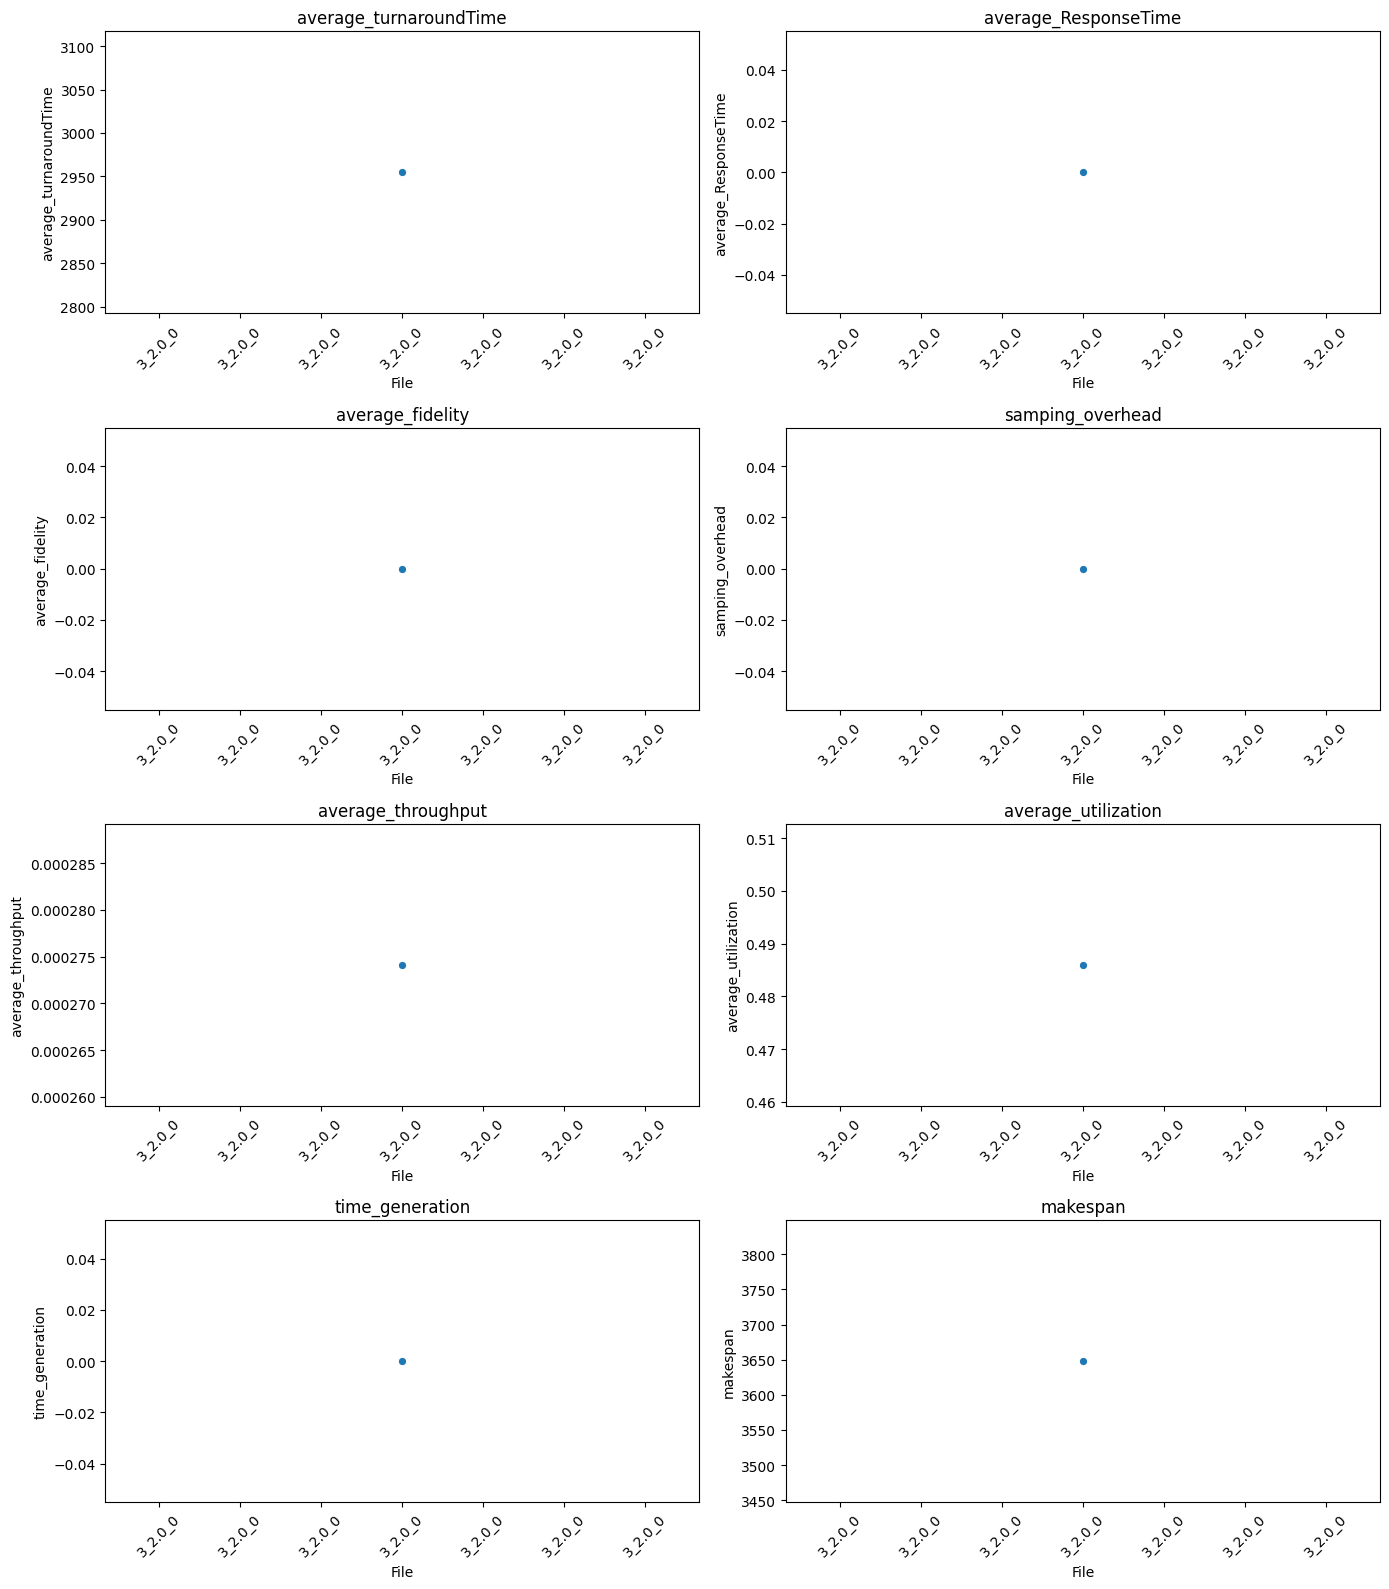

In [103]:
import os
import json
import re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker
import math

# Define the folder where your JSON files are stored
folder_path = os.path.join("component", "finalResult", result_Schedule.nameSchedule)

num_circuit = result_Schedule.numcircuit
num_qubits = result_Schedule.averageQubits

# Regex pattern to match filenames like 5_2.0_0.json, 5_2.0_1.json, etc.
pattern = re.compile(rf"{num_circuit}_{num_qubits}_(\d+)\.json")

# Metrics to extract from each JSON file
metrics = [
    "average_turnaroundTime",
    "average_ResponseTime",
    "average_fidelity",
    "samping_overhead",
    "average_throughput",
    "average_utilization",
    "time_generation",
    "makespan"
]

# Read data from matching JSON files
data = []
for file in os.listdir(folder_path):
    if pattern.match(file):
        with open(os.path.join(folder_path, file), "r") as f:
            content = json.load(f)
            entry = {metric: content[metric] for metric in metrics}
            entry["filename"] = file
            data.append(entry)

# Convert data to a pandas DataFrame
df = pd.DataFrame(data).sort_values(by="filename")

# Create subplots for each metric
fig, axes = plt.subplots(math.ceil(len(metrics) / 2), 2, figsize=(14, 16))
axes = axes.flatten()

for i, metric in enumerate(metrics):
    sns.lineplot(ax=axes[i], data=df, x=df["filename"].str.replace(".json", "", regex=False), y=metric, marker="o")
    axes[i].set_title(metric)
    axes[i].set_xlabel("File")
    axes[i].set_ylabel(metric)
    axes[i].tick_params(axis='x', rotation=45)
    axes[i].xaxis.set_major_locator(ticker.MaxNLocator(integer=True))

# Adjust layout and save to PDF
plt.tight_layout()
pdf_output_path = os.path.join(folder_path, "scheduling_metrics_plot.pdf")
plt.savefig(pdf_output_path)

print(f"Plot saved to: {pdf_output_path}")

Plot saved to: component/finalResult/MILQ_extend/scheduling_metrics_plot.pdf


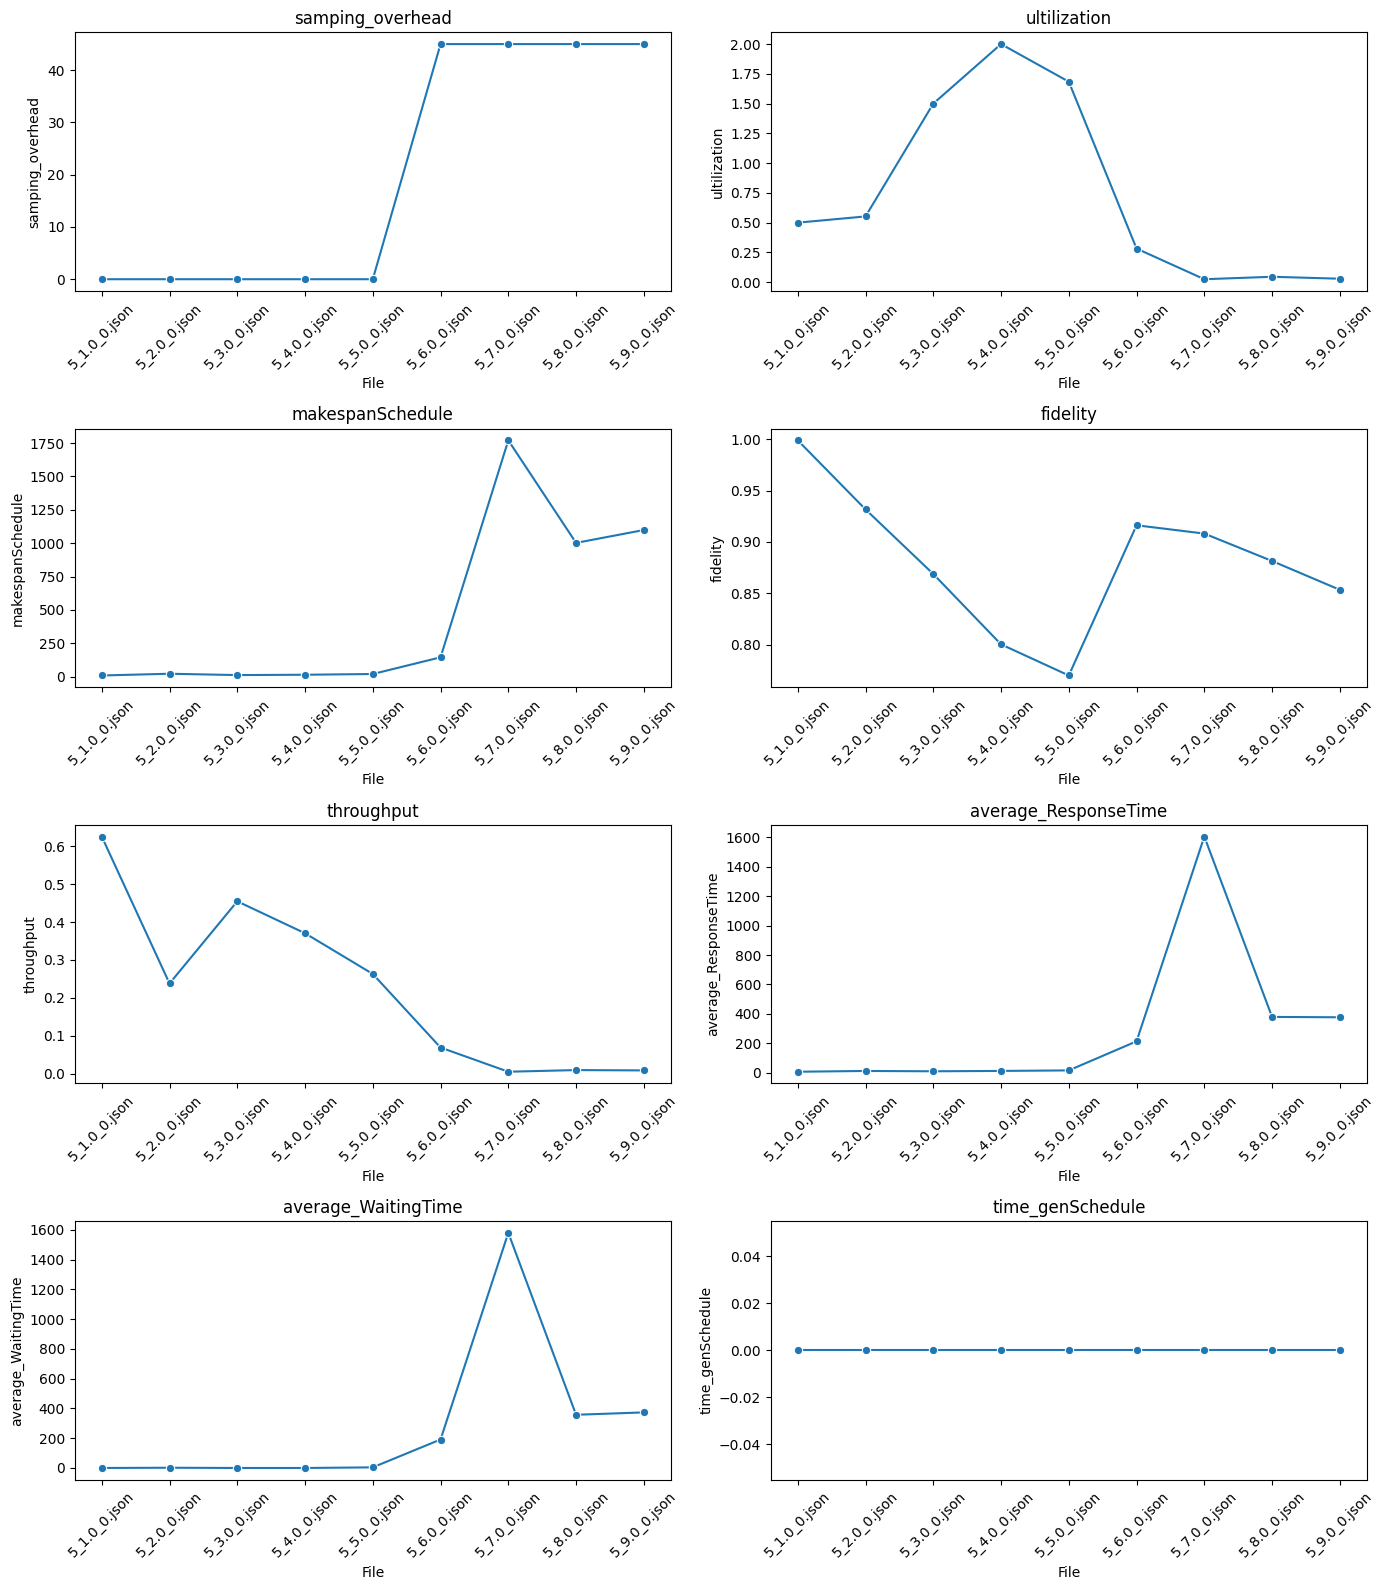

In [ ]:
import os
import json
import re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker
import math

# Define the folder where your JSON files are stored
folder_path = os.path.join("component", "finalResult", result_Schedule.nameSchedule)

num_circuit = result_Schedule.numcircuit
num_qubits = result_Schedule.averageQubits

# Regex pattern to match filenames like 5_2.0_0.json, 5_2.0_1.json, etc.
pattern = re.compile(rf"{num_circuit}_[1-9]\.0_0\.json")

# Metrics to extract from each JSON file
metrics = [
    "samping_overhead",
    "ultilization",
    "makespanSchedule",
    "fidelity",
    "throughput",
    "average_ResponseTime",
    "average_WaitingTime",
    "time_genSchedule"
]

# Read data from matching JSON files
data = []
for file in os.listdir(folder_path):
    if pattern.match(file):
        with open(os.path.join(folder_path, file), "r") as f:
            content = json.load(f)
            entry = {metric: content[metric] for metric in metrics}
            entry["filename"] = file
            data.append(entry)

# Convert data to a pandas DataFrame
df = pd.DataFrame(data).sort_values(by="filename")

# Create subplots for each metric
fig, axes = plt.subplots(math.ceil(len(metrics) / 2), 2, figsize=(14, 16))
axes = axes.flatten()

for i, metric in enumerate(metrics):
    sns.lineplot(ax=axes[i], data=df, x="filename", y=metric, marker="o")
    axes[i].set_title(metric)
    axes[i].set_xlabel("File")
    axes[i].set_ylabel(metric)
    axes[i].tick_params(axis='x', rotation=45)
    axes[i].xaxis.set_major_locator(ticker.MaxNLocator(integer=True))

# Adjust layout and save to PDF
plt.tight_layout()
pdf_output_path = os.path.join(folder_path, "scheduling_metrics_plot.pdf")
plt.savefig(pdf_output_path)

print(f"Plot saved to: {pdf_output_path}")